# Outline

* Today we will show how to train a ConvNet using PyTorch
* We will also illustrate how the ConvNet makes use of specific assumptions

# To perform well, we need to incorporate some prior knowledge about the problem

* Assumptions helps us when they are true
* They hurt us when they are not
* We want to make just the right amount of assumptions, not more than that

## In Deep Learning

* Many layers: compositionality
* Convolutions: locality + stationarity of images
* Pooling: Invariance of object class to translations

In [1]:
from plot_lib import plot_data, plot_model, set_default

In [2]:
set_default()

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,Dataset
from skimage import io,transform
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

# Load the Dataset


We can use some PyTorch DataLoader utilities for this. This will download, shuffle, normalize data and arrange it in batches.

In [4]:
class Datasets(Dataset): #Inherit Dataset
    def __init__(self, root_dir, transform=None): #_u init_u is some of the basic parameters to initialize this class
        self.root_dir = root_dir   #File directory
        self.transform = transform #Transform
        self.images = os.listdir(self.root_dir)#All files in the directory
    
    def __len__(self):#Returns the size of the entire dataset
        return len(self.images)
    
    def __getitem__(self,index):#Return dataset[index] based on index index index
        image_index = self.images[index]#Get the picture from the index index index
        img_path = os.path.join(self.root_dir, image_index)#Get the path name of the image index ed
        img = Image.open(img_path)# Read the picture
        label = img_path.split('/')[-1].split('.')[0]# The label of the picture is obtained from the path name of the picture, which is divided according to the path name.I'm here "E:\\Python Project\\Pytorch\\dogs-vs-cats\\train\cat.0.jpg", so first split with "\", select the last one as ['cat.0.jpg'], then split with "." and select [cat as the label for the picture
        #sample = {'image':img,'label':label}#Create a dictionary from pictures and labels
        if self.transform:
            img = self.transform(img)#Transform Samples
            
        return img, label #Return this sample

In [5]:
import os
num_workers = 0
# how many samples per batch to load
batch_size = 32


# define training, valid and test data directories
data_dir = './Cat_Dog_data/'
train_dir = os.path.join(data_dir, 'train/pets')
test_dir = os.path.join(data_dir, 'test/pets')

train_transforms = transforms.Compose([transforms.Resize(size=(224,224)),
                                    transforms.CenterCrop(size=224),
                                    transforms.ToTensor()])
#                                     transforms.Normalize([0.485, 0.456, 0.406],
#                                                          [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(size=(224,224)),
                                      transforms.CenterCrop(size=224),
                                    transforms.ToTensor()])
#                                     transforms.Normalize([0.485, 0.456, 0.406],
#                                                          [0.229, 0.224, 0.225])])


# train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
# test_data = datasets.ImageFolder(test_dir, transform=test_transforms)


In [6]:
train_data=Datasets(root_dir=train_dir, transform=train_transforms)
test_data=Datasets(root_dir=test_dir, transform=test_transforms)

train_loader=DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader=DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [7]:
train_data.__getitem__(2)

(tensor([[[0.1020, 0.0863, 0.0706,  ..., 0.4157, 0.4353, 0.4706],
          [0.0863, 0.0863, 0.0863,  ..., 0.4353, 0.4510, 0.4706],
          [0.0784, 0.1098, 0.1765,  ..., 0.4667, 0.4588, 0.4549],
          ...,
          [0.4471, 0.4275, 0.4980,  ..., 0.5961, 0.5333, 0.4431],
          [0.5373, 0.4824, 0.5098,  ..., 0.5451, 0.5059, 0.4706],
          [0.5569, 0.4824, 0.5137,  ..., 0.5216, 0.5020, 0.5333]],
 
         [[0.1333, 0.1255, 0.1137,  ..., 0.5529, 0.5725, 0.6078],
          [0.1333, 0.1294, 0.1451,  ..., 0.5686, 0.5804, 0.6039],
          [0.1490, 0.1765, 0.2510,  ..., 0.5922, 0.5804, 0.5765],
          ...,
          [0.4941, 0.4745, 0.5451,  ..., 0.6627, 0.5961, 0.5059],
          [0.5882, 0.5333, 0.5647,  ..., 0.6157, 0.5725, 0.5373],
          [0.6118, 0.5373, 0.5686,  ..., 0.5922, 0.5725, 0.6039]],
 
         [[0.1529, 0.1608, 0.1804,  ..., 0.3255, 0.3451, 0.3804],
          [0.1765, 0.1922, 0.2235,  ..., 0.3412, 0.3569, 0.3804],
          [0.2314, 0.2745, 0.3686,  ...,

In [8]:
input_size  = 224*224*3   # images are 224x224 pixels
output_size = 2      # there are 2 classes

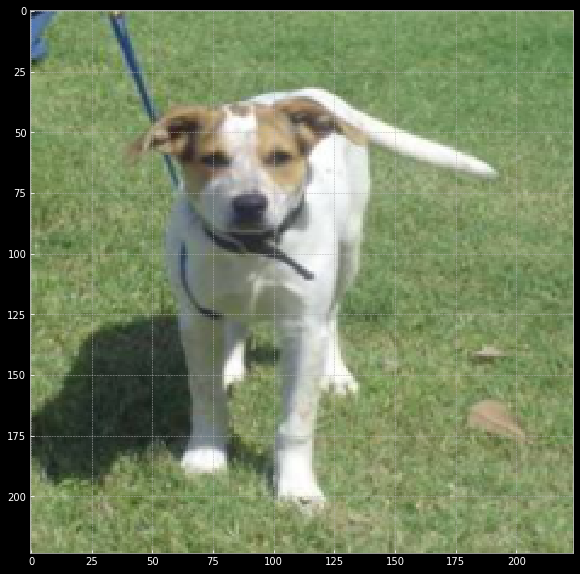

In [9]:
plt.imshow(train_data.__getitem__(2)[0].squeeze().numpy().transpose(1,2,0))

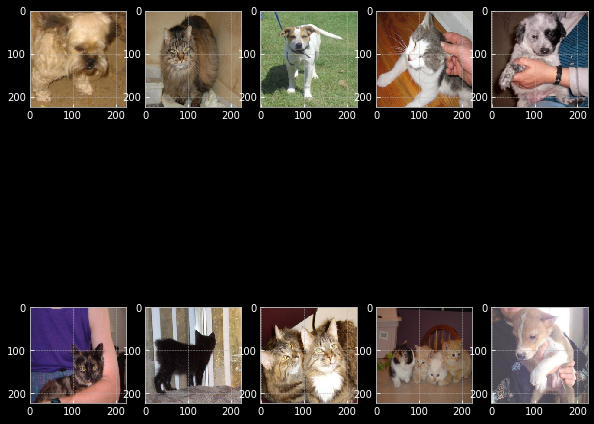

In [10]:
#show some images
plt.figure()
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy().transpose(1,2,0))

In [34]:
n_features=8
check_archi = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=n_features, kernel_size=5),
                            nn.MaxPool2d(2, 2),
                            nn.Conv2d(n_features, 2**2*n_features, kernel_size=7),
                            nn.MaxPool2d(2, 2),
                            nn.Conv2d(2**2*n_features, 2**2*n_features, kernel_size=2),
                            nn.MaxPool2d(2, 2),
                            nn.Conv2d(2**2*n_features, n_features, kernel_size=5),
                            nn.MaxPool2d(2,2))

In [35]:
filt, size = check_archi(torch.rand(1,3, 224, 224)).shape[1],\
        check_archi(torch.rand(1,3, 224, 224)).shape[2]
print(f'filter size {filt} and output shape {size}')

filter size 8 and output shape 10


In [36]:
train_loader.dataset.images;

# Create the model classes

In [38]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, output_size), 
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)
    
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, 2**2*n_feature, kernel_size=7)
        self.conv3 = nn.Conv2d(2**2*n_feature, 2**2*n_feature, kernel_size=2)
        self.conv4 = nn.Conv2d(2**2*n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*10*10, 50)
        self.fc2 = nn.Linear(50, 2)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*10*10)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [39]:
# for i, (j,k) in enumerate(train_loader):
#     print(i,k)
#     print()
#     print(j)

## Running on a GPU: device string

Switching between CPU and GPU in PyTorch is controlled via a device string, which will seemlessly determine whether GPU is available, falling back to CPU if not:

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [42]:
import pandas as pd

def funct(x):
    if x == 'cat':
        return 1
    else:
        return 0

accuracy_list = []

def train(epoch, model, perm=torch.arange(0, 50176).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        
        target=pd.Series(target)
        target=torch.from_numpy(target.apply(funct).values)
        # permute pixels
        data = data.view(-1, 224*224)
        data = data[:, perm]
        data = data.view(-1, 3, 224, 224)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, perm=torch.arange(0, 50176).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        target=pd.Series(target)
        target=torch.from_numpy(target.apply(funct).values)
        # permute pixels
        data = data.view(-1, 224*224)
        data = data[:, perm]
        data = data.view(-1, 3, 224, 224)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

# Train a small fully-connected network

In [20]:
n_hidden = 8 # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn)
    test(model_fnn)

# Train a ConvNet with the same number of parameters

In [46]:
# Training settings 
n_features = 8 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.6)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters: 63872
Train Epoch: 0 [0/22500 (0%)]	Loss: 0.694158
Train Epoch: 0 [3200/22500 (14%)]	Loss: 0.698314
Train Epoch: 0 [6400/22500 (28%)]	Loss: 0.695585
Train Epoch: 0 [9600/22500 (43%)]	Loss: 0.687530
Train Epoch: 0 [12800/22500 (57%)]	Loss: 0.693952
Train Epoch: 0 [16000/22500 (71%)]	Loss: 0.693654
Train Epoch: 0 [19200/22500 (85%)]	Loss: 0.688303
Train Epoch: 0 [22400/22500 (99%)]	Loss: 0.691792

Test set: Average loss: 0.6929, Accuracy: 1257/2500 (50%)



# The ConvNet performs better with the same number of parameters, thanks to its use of prior knowledge about images

* Use of convolution: Locality and stationarity in images
* Pooling: builds in some translation invariance

# What happens if the assumptions are no longer true?


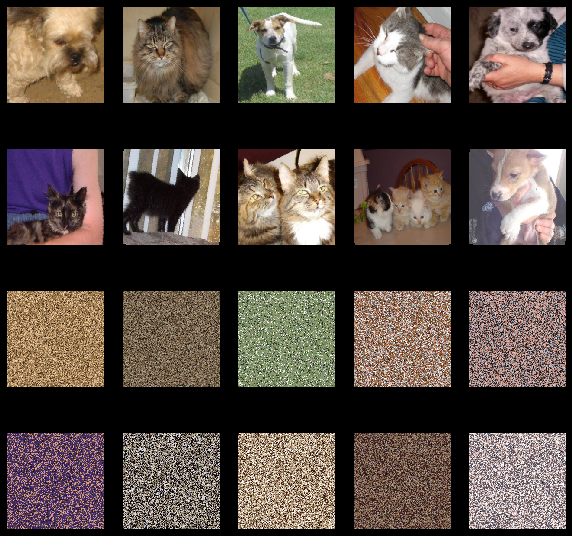

In [164]:
perm = torch.randperm(224*224)
plt.figure()
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permute pixels
    image_perm = image.view(-1, 224*224).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 3, 224, 224)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy().transpose(1,2,0))
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy().transpose(1,2,0))
    plt.axis('off')

# ConvNet with permuted pixels

In [165]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn, perm)
    test(model_cnn, perm)

Number of parameters: 875450
Train Epoch: 0 [0/22500 (0%)]	Loss: 0.693842
Train Epoch: 0 [2000/22500 (9%)]	Loss: 0.697433
Train Epoch: 0 [4000/22500 (18%)]	Loss: 0.695308
Train Epoch: 0 [6000/22500 (27%)]	Loss: 0.693237
Train Epoch: 0 [8000/22500 (36%)]	Loss: 0.693718
Train Epoch: 0 [10000/22500 (44%)]	Loss: 0.693077
Train Epoch: 0 [12000/22500 (53%)]	Loss: 0.689919
Train Epoch: 0 [14000/22500 (62%)]	Loss: 0.688079
Train Epoch: 0 [16000/22500 (71%)]	Loss: 0.692868
Train Epoch: 0 [18000/22500 (80%)]	Loss: 0.694825
Train Epoch: 0 [20000/22500 (89%)]	Loss: 0.696798
Train Epoch: 0 [22000/22500 (98%)]	Loss: 0.692142

Test set: Average loss: 0.6933, Accuracy: 1250/2500 (50%)



# Fully-Connected with Permuted Pixels

In [131]:
n_hidden = 8    # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn, perm)
    test(model_fnn, perm)

Number of parameters: 1204322
Train Epoch: 0 [0/22500 (0%)]	Loss: 0.688952
Train Epoch: 0 [2000/22500 (9%)]	Loss: 0.694292
Train Epoch: 0 [4000/22500 (18%)]	Loss: 0.686589
Train Epoch: 0 [6000/22500 (27%)]	Loss: 0.695912
Train Epoch: 0 [8000/22500 (36%)]	Loss: 0.665888
Train Epoch: 0 [10000/22500 (44%)]	Loss: 0.691047
Train Epoch: 0 [12000/22500 (53%)]	Loss: 0.646459
Train Epoch: 0 [14000/22500 (62%)]	Loss: 0.659427
Train Epoch: 0 [16000/22500 (71%)]	Loss: 0.678434
Train Epoch: 0 [18000/22500 (80%)]	Loss: 0.668419
Train Epoch: 0 [20000/22500 (89%)]	Loss: 0.657117
Train Epoch: 0 [22000/22500 (98%)]	Loss: 0.704643

Test set: Average loss: 0.6801, Accuracy: 1399/2500 (56%)



# The ConvNet's performance drops when we permute the pixels, but the Fully-Connected Network's performance stays the same

* ConvNet makes the assumption that pixels lie on a grid and are stationary/local
* It loses performance when this assumption is wrong
* The fully-connected network does not make this assumption
* It does less well when it is true, since it doesn't take advantage of this prior knowledge
* But it doesn't suffer when the assumption is wrong

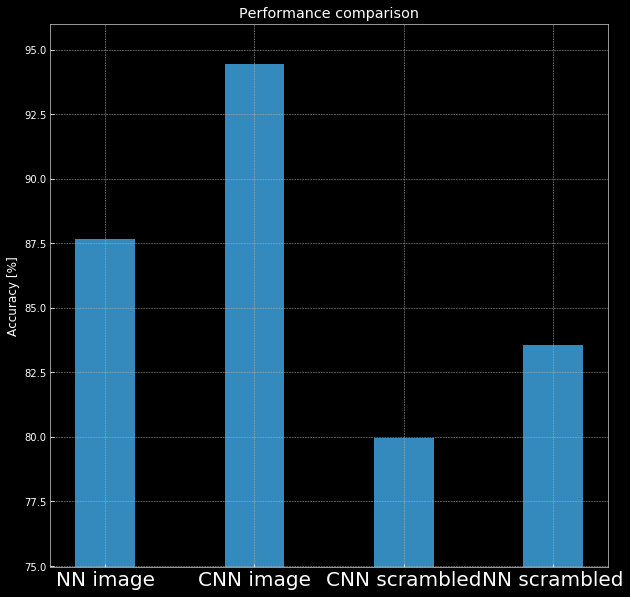

In [25]:
plt.bar(('NN image', 'CNN image',
         'CNN scrambled', 'NN scrambled'),
        accuracy_list, width=0.4)
plt.ylim((min(accuracy_list)-5, 96))
plt.ylabel('Accuracy [%]')
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
plt.title('Performance comparison');

### Checking Model Parameters

In [30]:
print(list(model_cnn.parameters())[0].size())

torch.Size([6, 1, 5, 5])


In [26]:
print(dir(model_cnn))

['__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_buffers', '_forward_hooks', '_forward_pre_hooks', '_get_name', '_load_from_state_dict', '_load_state_dict_pre_hooks', '_modules', '_named_members', '_parameters', '_register_load_state_dict_pre_hook', '_register_state_dict_hook', '_save_to_state_dict', '_slow_forward', '_state_dict_hooks', '_tracing_name', '_version', 'add_module', 'apply', 'buffers', 'children', 'conv1', 'conv2', 'cpu', 'cuda', 'double', 'dump_patches', 'eval', 'extra_repr', 'fc1', 'fc2', 'float', 'forward', 'half', 'load_state_dict', 'modules', 'n_feature', 'named_buffers', 'named_children', 'named_modules

In [31]:
print(list(model_fnn.parameters())[0].size())

torch.Size([8, 784])


In [27]:
print(dir(model_fnn))

['__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_buffers', '_forward_hooks', '_forward_pre_hooks', '_get_name', '_load_from_state_dict', '_load_state_dict_pre_hooks', '_modules', '_named_members', '_parameters', '_register_load_state_dict_pre_hook', '_register_state_dict_hook', '_save_to_state_dict', '_slow_forward', '_state_dict_hooks', '_tracing_name', '_version', 'add_module', 'apply', 'buffers', 'children', 'cpu', 'cuda', 'double', 'dump_patches', 'eval', 'extra_repr', 'float', 'forward', 'half', 'input_size', 'load_state_dict', 'modules', 'named_buffers', 'named_children', 'named_modules', 'named_parameters', 'network